In [2]:
# importing libraries
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [1]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [5]:
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [226]:
def build_dataset(words):
    block_size = 3
    X, Y = [], []
    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '---->',itos[ix])
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtes, Ytes = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [124]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [283]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,10), generator=g)
w1 = torch.randn((30,200), generator=g)
b1 = torch.randn((200), generator=g)
w2 = torch.randn((200, 27), generator=g)
b2 = torch.randn((27), generator=g)
parameters = [C, w1, b1, w2, b2]

In [284]:
sum(p.nelement() for p in parameters)

11897

In [285]:
for p in parameters:
    p.requires_grad = True

In [205]:
lre = torch.linspace(-3, 0, 1000) # it was used for learning rate
lrs = 10**lre

In [286]:
lri = []
lossi = []
stepsi = []

In [309]:
for i in range(300000):
    # batch size 32
    ix = torch.randint(0, Xtr.shape[0], (32,))
    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 30) @ w1 + b1)
    logits = h @ w2 +b2
    #counts = logits.exp()
    #probs = counts / counts.sum(1, keepdims=True)
    #loss = probs[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update parameters
    #lr = lrs[i]
    if i < 150000:
        lr = 0.1
    elif i > 150000 and i < 250000: 
        lr = 0.01
    else: lr = 0.001
    for p in parameters:
        p.data += -lr * p.grad
    #lri.append(lre[i])
    stepsi.append(i)
    lossi.append(loss.log().item())
#print(loss.item())   

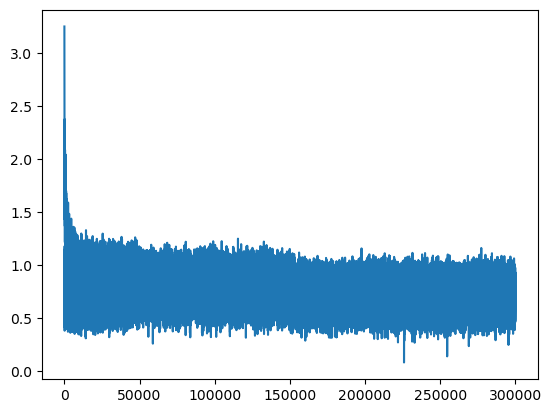

In [310]:
plt.plot(stepsi, lossi)

In [311]:
emb = C[Xtr] #2.1626
h = torch.tanh(emb.view(-1, 30) @ w1 + b1)
logits = h @ w2 +b2
loss = F.cross_entropy(logits, Ytr)
loss.item()

2.0768816471099854

In [312]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ w1 + b1)
logits = h @ w2 +b2
loss = F.cross_entropy(logits, Ydev)
loss.item()

2.134321451187134

In [313]:
emb = C[Xtes]
h = torch.tanh(emb.view(-1, 30) @ w1 + b1)
logits = h @ w2 +b2
loss = F.cross_entropy(logits, Ytes)
loss.item()

2.137144088745117

In [316]:
# taking samples from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ w1 + b1)
        logits = h @ w2 +b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

mora.
kayah.
seel.
nihayla.
renyrelendra.
gradelyn.
elin.
shi.
jen.
eden.
esmanaraelyn.
malara.
noshubergahiriel.
kindreelynn.
novana.
urzenedi.
jamell.
els.
kay.
mys.


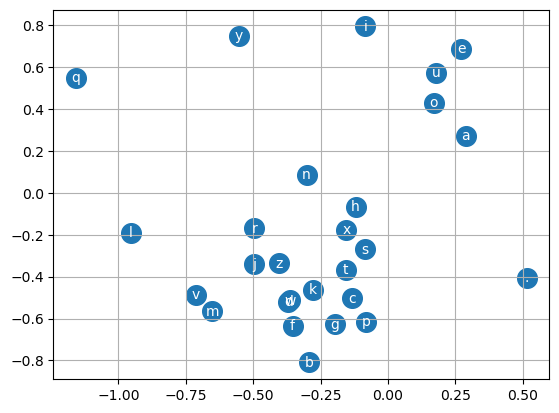

In [278]:
# this was the 2d embedding of words after traning but then we switch to 10 vector for improvement
plt.figure(figure=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')